# Differential Algebraic Equations (DAEs)
**Prepared by:** Prof. Alexander Dowling, Myia Dickens (mdicken2@nd.edu, 2023), Molly Dougher (mdoughe6@nd.edu, 2023)

In [1]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    !pip install casadi
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()


## External Documentaiton for libraries used
Pyomo.dae documentation:
* https://pyomo.readthedocs.io/en/latest/modeling_extensions/dae.html


CasADi (need to integrate DAEs):
* https://web.casadi.org/get/
* For local installation: ```pip install casadi```. Warning: installing `CasADi` with `conda` will install an "okay" version of Ipopt. If you really want to install `CasADi` with `conda`, you'll likely need to add `import idaes` to your notebook to load the "good" version of Ipopt (Linux and Windows users).

## Dynamic Optimization Overview

### Introduction to Dynamic Optimization
Dynamic systems can be found in a wide range of engineering fields and subfields. This section is meant to be an introduction to solve differentiable-algebraic equations (DAEs) with resepct to optimizing dynamic systems. To allow for uniform understanding, the examples and explanations in this notebook will focus on basic physics examples (i.e. the pendulum example) and explanations. 

DAEs are tpyically specified as initial value problems with initial coniditions at zero. These equations are experessed with resepct to an independent variable, $t$, and are typically autnomous, or $t$ does not explicilty appear in the equation. 

DAEs are tpyically of the form:

\begin{align}
F\left(x, \frac{d x}{d t}, u(t), p, t\right)=0, \quad h(x(0))=0
\end{align}

$x(t)$: state variables, functions of time 

$u(t)$: control variables, functions of time

$p$: variables, independent of $t$

With respect to optimizing DAEs, the equations are structured to the simpler form:

\begin{equation}
\frac{d z}{d t}= f(z(t), y(t), u(t), p), \quad z(0)=z_0, \quad
g(z(t), y(t), u(t), p)=0
\end{equation}

where the state variables $x(t)$ is partioned into differenetiable varibales, $z(t)$, and algebraic variables $y(t)$. It is assumed that $y(t)$ can be solved independetly from $z(t)$, $u(t)$, and $p$, which allows for the DAE to be treated as an ODE of the form: 

\begin{align}
\frac{d z}{d t}=f(z(t), y[z(t),u(t),p], u(t), p)= \bar f(z(t), u(t), p), \quad z(0)=0
\end{align}

The section, Handling Path Constraints, will explain DAE indexing and how to reduce the index of a DAE to allow it to be treated as an ODE. 

## General Breakdown of DAEs

With resepct to constructing DAEs:


*   $z(t)$: Differential equations are typically dervied from conservation laws.
*   $y(t)$ : Algebraic equations are typiclaly derived from constitutive and equilbrium laws. 
*   The decision variables of the system fall under the two following variables:
 *  $u(t)$ : the control variables include manipulated variables that change over time.
 * $p$ : time-independent variables that correspond to parameteres, initial conditions, and other steady state conditions.

## DAEs as Boundary Value Problems
Because DAEs are typically initial value problems, they can also be boundary value problems (BVP), where the initial condition is replaced by bondary conditions. With respect to solving DAE optimization problems, BVP DAEs are of the form: 
\begin{align}
\frac{d z}{d t}=\hat f(z(t)), \quad h(z(0),z[t_f;z(0)])=0
\end{align}

In this form the solutions may be nonunique or not exist over a speficied reason; therefore, a key property is finding a locally unique solution, expressed by the theorem:



> **Theorem 8.2**: Consider the BVP DAE with solution $ \hat z(t)$. Also let $\bar f(z(t))$ be Lipschitz continuous for all z(t) $|| z(t) - \hat z(t) || \leq \epsilon$ for some $\epsilon > 0$ and $t \in [0, t_f]$. Then  the solution $\hat z(t)$ is locally unique if and only if the matrix:
>
> \begin{align}
Q(t) = \frac{\partial h\left(\hat{z}(0), \hat{z}\left(t_f\right)\right)}{\partial z(0)}+Z(t) \frac{\partial h\left(\hat{z}(0), \hat{z}\left(t_f\right)\right)}{\partial z\left(t_f\right)}
\end{align}
> 
> is nonsingular, where the fundamental solution matrix $Z(t) = \frac{dz(t_f)}{dz(0)}$ is evaluated at the solution $\hat z(t)$. 

Theorem 8.2 is important when designing DAE constrained optimization problems.

## DAE Optimization
Typically dynamic systems needed to be optimized over multiple periods, $l = 1,..., N_T$, in a time range, $t$. The model, states, and decisions can change during each period, $t \in (t_{l-1}, t_l]$ , or over multiple periods. The multiperiod, dynamic optimization problem is of the form:

\begin{align}
\min & \sum_{l=1}^{N_T} \Phi^l\left(z^l\left(t_l\right), y^l\left(t_l\right), u^l\left(t_l\right), p^l\right) \\
\text { s.t. } & \frac{d z^l}{d t}=f^l\left(z^l(t), y^l(t), u^l(t), p^l\right), \quad z^l\left(t_{l-1}\right)=z_0^l, \\
& g^l\left(z^l(t), y^l(t), u^l(t), p^l\right)=0, \\
& u_L^l \leq u^l(t) \leq u_U^l, \\
& p_L^l \leq p^l \leq p_U^l, \\
& y_L^l \leq y^l(t) \leq y_U^l, \\
& z_L^l \leq z^l(t) \leq z_U^l, \quad t \in\left(t_{l-1}, t_l\right], l=1, \ldots, N_T, \\
& h\left(p, z_0^1, z^1\left(t_1\right), z_0^2, z^2\left(t_2\right), \ldots, z_0^{N_T}, z^{N_T}\left(t_{N_T}\right)\right)=0
\end{align}

In this form, it is assumed that the state variables are not continuous across periods; therefore, the last line is meant to connect the states of each period. The initial conditions and inequality constraints are represented as simple bounds in this form. 

Key applications of DAEs and Dynamic Optimization are as follows:

* Chemical Reactor Design
* Parameter Estimation of a Dynamic System
* Batch Process Estimation
* Dynamic Real-Time Optimization

A desciption and further explanation of these applications can be found in Chapter 8 of the Biegler (2010) textbook.

## Handling Path Constraints
*Information taken from Section 8.4 of Biegler (2010).*



The motivation for defining the *index* of a DAE system starts with considering the general algebraic equality constraint $g_E(z,y,u,p)=0$. After the algebraic and control variables are established, deriving the Euler-Lagrange equations requires variable and equation nesting. In order to be nested, the algebraic variables must be able to be implicitly emliminated from their paired algebraic equation. If $y(t)$ cannot be implicitly eliminated from this algebraic equality, reformulation is needed. This reformulation  begins with establishing an index of a DAE system.

### DAE Index and Index Reduction
> **Definition 8.6**: Consider the DAE systems of the form: 
> 
> \begin{align}
F\left(x, \frac{d x}{d t}, u(t), p, t\right)=0, \quad h(x(0))=0
\end{align}
> 
> OR 
> 
> \begin{equation}
\frac{d z}{d t}= f(z(t), y(t), u(t), p), \quad z(0)=z_0, \quad
g(z(t), y(t), u(t), p)=0
\end{equation}
> 
> with decisions $u(t$) and $p$ fixed. The index is the integer $s$ that represents the minimum number of differentiations of the DAE system (with no respect to time) required to determine an ODE for the variables $z(t)$ and $y(t)$.

Generally, for semiexplicit systems, the index of a DAE system can be determined by first differentiating the algebraic equations and then substituting resulting differential terms into the respective differential equation. Recall the number of differentiations required to isolate an ODE system corresponds to the index.

As the goal is usually to isolate a DAE of index 1, the following algorithm describes the typical procedure to reduce the index of a DAE system.

> **Algorithm 8.1**: (Reduction of High Index DAEs)
Start with a DAE of the form:
> 
> \begin{equation}
\frac{d z}{d t}= f(z(t), y(t), u(t), p), \quad z(0)=z_0, \quad g(z(t), y(t), u(t), p)=0.
\end{equation}
> 
> 1. Check if the DAE system is index 1. If yes, stop.
> 2. Identify a subset of algebraic equations that can be solved for a subset of algebraic variables.
> 3. Consider the remaining algebraic equations that contain differential variables $z_j$. Differentiating these remaining algebraic equations with respect to time leads to terms $\frac{dz_j}{dt}$ in the differentiated equations.
> 4. For the differential terms $\frac{dz_j}{dt}$, substitute the right-hand sides of the corresponding differential equations $f_j(z,y,u,p)$ into the differentiated algebraic equations, and eliminate (some of) these differential equations. This leads to new algebraic equations that replace the same number of existing differential equations.
> 5. With this new DAE system, go to step 1.

An example of this algorithm in use can be found within the following pendulum example.

### Pendulum model and index reduction
Pendulum example:
* Python version of example: http://apmonitor.com/wiki/index.php/Apps/PendulumMotion
* More details on index reduction for example: https://www.lehigh.edu/~wes1/apci/11may00.pdf

```{tikz}
\begin{tikzpicture}

% Drawing the pivot point
\filldraw[black] (-1, 3) ellipse (0.1cm and 0.1cm);

% Drawing the pendulum arm
\draw[thick] (-1, 3) -- (2, -2) ;

\node at (1,1) {\Large $L = 1$} ;

% Coordinate axes at the bob's position
\draw[->, thick] (2, -2) -- (0, -2) node[left] {\Large $x$};
\draw[->, thick] (2, -2) -- (2, -4) node[below] {\Large $y$};

% Drawing the mass (bob) at the end of the pendulum
\filldraw[blue] (2, -2) circle (1cm);

% Drawing the angle arc
\draw[-, dashed] (-1, 3) -- (-1, 1.5) node[right] {\Large $\theta$};


\node at (2,-2) {\Large $m = 1$} ;

\end{tikzpicture}
```





The following DAE system describes the pendulum system:

\begin{align}
& x' = u \\
& y' = v \\
& u' = -Tx \\
& v' = g - Ty \\
& x^2 + y^2 = 1 \\
\end{align}

To find the index of the DAE system, first take the derivative of the algebraic equation and substitute in for the differential variables:

\begin{align}
& x^2 + y^2 = 1 \\
& 2xx' + 2yy' = 0 \\
& 2xu + 2yv = 0
\end{align}

Next, differentiate the obtained equation using the product rule, make similar substitutions, and rearrange:

\begin{align}
& 2xu + 2yv = 0 \\
& 2(xu'+ x'u) + 2(yv' + vy') = 0 \\
& 2(-Tx^2 + u^2) + 2(y(g-Ty) + v^2) = 0 \\
& 2(u^2 + v^2) + 2(-Tx^2 + gy - Ty^2) = 0 \\
& 2(u^2 + v^2) - 2T(x^2 + y^2) + 2gy = 0
\end{align}

Finally, implicitly differentiate the obtained equation, make similar substitutions, and rearrange to isolate the $T'$ term:

\begin{align}
& 2(u^2 + v^2) - 2T(x^2 + y^2) + 2gy = 0 \\
& 4(uu' + vv') - 4T(xx' + yy') - 2T'(x^2 + y^2) + 2gy' = 0 \\
& 4(uu' + vv') - 4T(xx' + yy') + 2gy' = 2T'(x^2 + y^2) \\
& 4(-Tux + v(g-Ty)) - 4T(xu + yv) + 2gv = 2T' \\
& 4(-Tux -Tyv + gv) - 4T(xu + yv) + 2gv = 2T' 
\end{align}

Now the equations are a system of ODEs. Three differentiations were completed, indicating that this is an **Index 3 DAE**.

To reduce this DAE to index 1, follow Algorithm 8.1. The above analysis shows that this is not an index 1 DAE system. Therefore, the following algebraic equation is identified: $x^2 + y^2 = 1$. Differentiate the algebraic equation to yield:
\begin{align}
& 2xx' + 2yy' = 0\\
\end{align}
which can be solved for $x'$. Substitute for $x'$ and $y'$ to yield:
\begin{align}
& 2xu + 2yv = 0\\
\end{align}
The new DAE system is now:
\begin{align}
& y' = v \\
& u' = -Tx \\
& v' = g - Ty \\
& x^2 + y^2 = 1 \\
& 2xu + 2yv = 0 \\
\end{align}
where $x$ is now an algebraic variable and the final equation must be solved for $T$. Differentiating the algebraic (last) equation leads to:
\begin{align}
& 2(xu'+ x'u) + 2(yv' + vy') = 0 \\
& 2(xu' + u^2) + 2(yv' + v^2) = 0 \\
& 2(u^2 - Tx^2) + 2(v^2 + gy - Ty^2) = 0 \\
\end{align}
The equations can replace $u' = -Tx$, leading to the following DAE system:
\begin{align}
& y' = v \\
& v' = g - Ty \\
& x^2 + y^2 = 1 \\
& (u^2 + v^2) - T(x^2 + y^2) + gy = 0 \\
\end{align}
which is an **Index 1 DAE**.

In [2]:
## Load libraries
import pyomo.environ as pyo
import pyomo.dae as dae
from pyomo.dae.simulator import Simulator
import matplotlib.pyplot as plt
import numpy as np

## Define function for plotting results
def plot_results(sim, tsim, profiles):

    '''
    inputs:

    sim: pyomo.DAE simulator results from a simulation of ODE or DAE
    tsim: 1D array of time samples of the DAE/ODE simulatiion
    profiles: 2D array of simulated differential and algebraic equations

    outputs:

    Plot 1: A plot of the curated profiles
    Plot 2: A plot of the simulated results

    time = list(m.t)
    x = [value(m.x[t]) for t in m.t]
    y = [value(m.y[t]) for t in m.t]

    plt.plot(time, x, '-b', label='x')
    plt.plot(time, y, '-r', label='y')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend(loc='best')
    plt.show()
    '''
    
    plt.figure(1,figsize=(4,4))
    varorder = sim.get_variable_order()
    algorder = sim.get_variable_order(vartype='algebraic')

    # Create empty dictionary
    results = {}
    
    # Collect Different Profiles
    for idx1, v in enumerate(varorder):
        i = idx1
        v_ = str(v)
        results[v_] = profiles[:, i]
        plt.plot(tsim, results[v_], label=v)

    
    # Collect Algebraic Profiles
    for idx2, v in enumerate(algorder):
        i = len(varorder) + idx2
        v_ = str(v)
        results[v_] = profiles[:, i]
        plt.plot(tsim, results[v_], label=v)
    
    # Plot the simulated algebraic and differential profiles as they change in time
    plt.xlabel('t', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in",labelsize=15)
    plt.legend(loc='best')
    
    plt.show()
    
    # Plot the results of the simulation
    plt.figure(2,figsize=(4,4))
    x_ = results['x[{t}]']
    y_ = results['y[{t}]']
    plt.plot(tsim, np.sqrt(x_**2 + y_**2), '-b', label='length')
    plt.xlabel('t', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in",labelsize=15)
    plt.ylabel('$\sqrt{x^2 + y^2}$')
    plt.show()
    
    #return results

### Formulation 1: Index-3 DAE

Consider the following model:

$$\begin{align}
\frac{d x}{dt} &= u \\
\frac{d y}{dt} &= v \\
\frac{d u}{dt} &= -T x \\
\frac{d v}{dt} &= g - Ty \\
& x^2 + y^2 = 1
\end{align}$$

This assumes mass and length of unity.

In [3]:
def create_model_index3():
    '''
    Creates a model to define the Index 3 DAE system.

    Output: the model, m
    '''

    m = pyo.ConcreteModel()

    # Declare time
    m.t = dae.ContinuousSet(bounds=(0.0, 1))

    # Declare parameter - acceleration due to gravity
    m.g = pyo.Param(initialize=9.81) # m/s^2

    # Declare variables indexed over time
    m.x = pyo.Var(m.t) # horizontal position
    m.y = pyo.Var(m.t) # vertical position
    m.u = pyo.Var(m.t) # horizontal velocity
    m.v = pyo.Var(m.t) # vertical velocity
    m.T = pyo.Var(m.t) # tension

    # Declare derivative variables
    m.dx = dae.DerivativeVar(m.x) # with respect to t is implied
    m.dy = dae.DerivativeVar(m.y)
    m.du = dae.DerivativeVar(m.u)
    m.dv = dae.DerivativeVar(m.v)

    # Declare differential equations
    def _dx_eqn(m, t):
        return m.dx[t] == m.u[t]
    m.dx_eqn = pyo.Constraint(m.t, rule=_dx_eqn)

    def _dy_eqn(m, t):
        return m.dy[t] == m.v[t]
    m.dy_eqn = pyo.Constraint(m.t, rule=_dy_eqn)

    def _du_eqn(m, t):
        return m.du[t] == -m.T[t]*m.x[t]
    m.du_eqn = pyo.Constraint(m.t, rule=_du_eqn)

    def _dv_eqn(m, t):
        return m.dv[t] == m.g -m.T[t]*m.y[t]
    m.dv_eqn = pyo.Constraint(m.t, rule=_dv_eqn)

    # Declare algebraic equation
    def _alg_eqn(m, t):
        return m.x[t]**2 + m.y[t]**2 == 1
    m.alg_eqn = pyo.Constraint(m.t, rule=_alg_eqn)

    # Specify initial conditions
    m.x[0] = 0
    m.y[0] = 1
    m.u[0] = 1
    m.v[0] = 0
    m.T[0] = 1 + m.g
    
    return m

index3 = create_model_index3()

# Specify integrator options
int_ops = {'print_stats':True,"abstol":1E-8,"reltol":1E-6}

# Solve DAEs
sim = Simulator(index3, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)

# Plot solution
plot_results(sim, tsim, profiles)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0 and h = 1.06624e-14, the corrector convergence failed repeatedly or with |h| = hmin.


RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.

**Warning**: If you run this notebook in Colab, you may get the following runtime error and your kernel may crash:

![casadi-error-1](https://raw.githubusercontent.com/ndcbe/optimization/main/media/casadi-error1.png)

![casadi-error-2](https://raw.githubusercontent.com/ndcbe/optimization/main/media/casadi-error2.png)

Why did the `IDAS` integrator in `SUNDIALS` fail? It is [only meant for index 0 or 1 DAEs](https://groups.google.com/g/casadi-users/c/E02-X6nGVFs)! Integrating high index DAEs is really hard!

### Formulation 2: Pure ODE Model/ Index-0 Example

$$\begin{align}
\frac{d x}{dt} &= u \\
\frac{d y}{dt} &= v \\
\frac{d u}{dt} &= -T x \\
\frac{d v}{dt} &= g - Ty \\
\frac{d T}{dt} &= 4 T (x u + y v) + 3 g v
\end{align}$$


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 167
Number of calls to the user’s f function: 242
Number of calls made to the linear solver setup function: 31
Number of error test failures: 7
Method order used on the last internal step: 5
Method order to be used on the next internal step: 5
Actual value of initial step size: 7.90569e-07
Step size taken on the last internal step: 0.00246466
Step size to be attempted on the next internal step: 0.00492933
Current internal time reached: 0.00492933
Number of nonlinear iterations performed: 240
Number of nonlinear convergence failures: 0



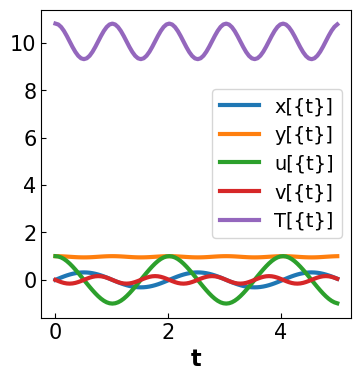

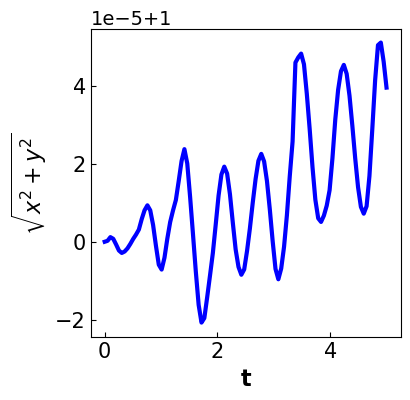

In [4]:
def create_model_ode():
    '''
    Creates a model to define the Index 0 DAE system.

    Output: the model, m
    '''

    m = pyo.ConcreteModel()

    # Declare time
    m.t = dae.ContinuousSet(bounds=(0.0, 5.0))

    # Declare parameter - acceleration due to gravit
    m.g = pyo.Param(initialize=9.81) # m/s^2

    # Declare variables indexed over time
    m.x = pyo.Var(m.t) # horizontal position
    m.y = pyo.Var(m.t) # vertical position
    m.u = pyo.Var(m.t) # horizontal velocity
    m.v = pyo.Var(m.t) # vertical velocity
    m.T = pyo.Var(m.t) # tension

    # Declare derivative variables
    m.dx = dae.DerivativeVar(m.x) # with respect to t is implied
    m.dy = dae.DerivativeVar(m.y)
    m.du = dae.DerivativeVar(m.u)
    m.dv = dae.DerivativeVar(m.v)
    m.dT = dae.DerivativeVar(m.T)

    # Declare differential equations
    def _dx_eqn(m, t):
        return m.dx[t] == m.u[t]
    m.dx_eqn = pyo.Constraint(m.t, rule=_dx_eqn)

    def _dy_eqn(m, t):
        return m.dy[t] == m.v[t]
    m.dy_eqn = pyo.Constraint(m.t, rule=_dy_eqn)

    def _du_eqn(m, t):
        return m.du[t] == -m.T[t]*m.x[t]
    m.du_eqn = pyo.Constraint(m.t, rule=_du_eqn)

    def _dv_eqn(m, t):
        return m.dv[t] == m.g -m.T[t]*m.y[t]
    m.dv_eqn = pyo.Constraint(m.t, rule=_dv_eqn)

    def _dT_eqn(m, t):
        return m.dT[t] == 4*m.T[t]*(m.x[t]*m.u[t] + m.y[t]*m.v[t]) + 3*m.g*m.v[t]
    m.dT_eqn = pyo.Constraint(m.t, rule=_dT_eqn)

    # Specify initial conditions
    m.x[0] = 0
    m.y[0] = 1
    m.u[0] = 1
    m.v[0] = 0
    m.T[0] = 1 + m.g
    
    return m

ode = create_model_ode()

# Specify integrator options
int_ops = {'print_stats':True,"abstol":1E-6,"reltol":1E-4}

# Solve DAEs
sim = Simulator(ode, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)

# Plot solution
results = plot_results(sim, tsim, profiles)

**Discussion**
* Are all of the algebraic constraints in the original formulation satisfied?

### Formulation 3: Index-1 DAE Model

$$\begin{align}
\frac{d y}{dt} &= v \\
\frac{d v}{dt} &= g - Ty \\
 & x^2 + y^2 = 1 \\
 & 2 x u + 2 y v = 0 \\
 & (u^2 + v^2) - T (x^2 + y^2) + g y = 0
\end{align}$$

(This reformulation is NOT unique... could have written $\frac{dx}{dt}$ and $\frac{du}{dt}$ instead.)

Consistent initial conditions:
1. Specify $y(0)$ and $v(0)$.
2. Solve for $x(0)$, $u(0)$, and $T(0)$

In [5]:
def create_model_index1():
    '''
    Creates a model to define the Index 1 DAE system.

    Output: the model, m
    '''

    m = pyo.ConcreteModel()

    # Declare time
    m.t = dae.ContinuousSet(bounds=(0, 5))

    # Declare parameter - acceleration due to gravity
    m.g = pyo.Param(initialize=9.81) # m/s^2

    # Declare variables indexed over time
    m.x = pyo.Var(m.t) # horizontal position
    m.y = pyo.Var(m.t) # vertical position
    m.u = pyo.Var(m.t) # horizontal velocity
    m.v = pyo.Var(m.t) # vertical velocity
    m.T = pyo.Var(m.t) # tension

    # Declare derivative variables
    m.dy = dae.DerivativeVar(m.y)
    m.dv = dae.DerivativeVar(m.v)

    # Declare differential equations
    def _dy_eqn(m, t):
        return m.dy[t] == m.v[t]
    m.dy_eqn = pyo.Constraint(m.t, rule=_dy_eqn)

    def _dv_eqn(m, t):
        return m.dv[t] == m.g - m.T[t]*m.y[t]
    m.dv_eqn = pyo.Constraint(m.t, rule=_dv_eqn)

    # Declare algebraic equations
    def _alg_eqn1(m, t):
        return m.x[t]**2 + m.y[t]**2 == 1
    m.alg_eqn1 = pyo.Constraint(m.t, rule=_alg_eqn1)

    def _alg_eqn2(m, t):
        return m.x[t]*m.u[t] + m.y[t]*m.v[t] == 0
    m.alg_eqn2 = pyo.Constraint(m.t, rule=_alg_eqn2)

    def _alg_eqn3(m, t):
        return m.u[t]**2 + m.v[t]**2 - m.T[t]*(m.x[t]**2 + m.y[t]**2) + m.g*m.y[t] == 0
    m.alg_eqn3 = pyo.Constraint(m.t, rule=_alg_eqn3)

    # Specify initial conditions
    m.x[0] = 0
    m.y[0] = 1
    m.u[0] = 1
    m.v[0] = 0
    m.T[0] = 1 + m.g
    
    return m

def index1_check_constraints(m):
    """ Check if the three constraints are feasible.
    """
    
    print("Constraint 1:")
    r1 = m.x[0]()**2 + m.y[0]()**2 - 1
    print(r1)
    
    print("\nConstraint 2:")
    r2 = m.x[0]()*m.u[0]() + m.y[0]()*m.v[0]()
    print(r2)
    
    print("\nConstraint 3:")
    r3 = m.u[0]()**2 + m.v[0]()**2 - m.T[0]() + m.g*m.y[0]()
    print(r3)

index1 = create_model_index1()

# Check initial condition
index1_check_constraints(index1)

# Specify integrator options
int_ops = {'print_stats':True,"abstol":1E-6,"reltol":1E-4}

# Solve DAEs
sim = Simulator(index1, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)
# tsim, profiles = sim.simulate(numpoints=100, integrator='collocation')

Constraint 1:
0

Constraint 2:
0

Constraint 3:
0.0


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.


RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_NO_RECOVERY". Consult IDAS documentation.

What happened? [Point singularity](https://sourceforge.net/p/casadi/discussion/1271244/thread/1d895c9e/) at $x=0$.

Let's try $x=0.1$ as the initial point.

In [6]:
index1_again = create_model_index1()

# Specify alternative initial conditions
small_number = 0.1

index1_again.x[0] = small_number
index1_again.y[0] = 1
index1_again.u[0] = 1
index1_again.v[0] = 0
index1_again.T[0] = 1 + index1_again.g

# Check initial condition
index1_check_constraints(index1_again)

# Solve DAEs
sim = Simulator(index1_again, package='casadi')

# Simulator
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)

Constraint 1:
0.010000000000000009

Constraint 2:
0.1

Constraint 3:
0.0


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.


RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_NO_RECOVERY". Consult IDAS documentation.

Our initial point does not satisfy the algebraic constraints! We need a consistent initial point.

Given $x = \epsilon$, solve $x^2 + y^2 = 1$ for $y$:

$$ y = \sqrt{1^2 - \epsilon^2}$$

Then, assume $u = 1$ and solve $2 x u + 2 y v = 0$ for $v$:

$$v = \frac{-x u}{y}$$

Finally, we can solve $(u^2 + v^2) - T (x^2 + y^2) + g y = 0$ for $T$:

$$
T = \frac{(u^2 + v^2) + gy}{x^2 + y^2} = \frac{(u^2 + v^2) + gy}{1}
$$

In [7]:
index1_take_two = create_model_index1()

# Specify alternative initial conditions
small_number = 0.1

index1_take_two.x[0] = small_number
index1_take_two.y[0] = np.sqrt(1 - small_number**2)
index1_take_two.u[0] = 1
index1_take_two.v[0] = -index1_take_two.x[0]()*index1_take_two.u[0]()/index1_take_two.y[0]()
index1_take_two.T[0] = (index1_take_two.u[0]()**2 + index1_take_two.v[0]()**2
    + index1_take_two.g*index1_take_two.y[0]())

# Check initial condition
index1_check_constraints(index1_take_two)

# Solve DAEs
sim = Simulator(index1_take_two, package='casadi')

# Specify integrator options
int_ops2 = {'print_stats':True,"abstol":1E-6,"reltol":1E-4,
            "verbose":False,"calc_ic":True}

# Simulator
tsim, profiles = sim.simulate(numpoints=20, integrator='idas',integrator_options=int_ops2)

Constraint 1:
0.0

Constraint 2:
0.0

Constraint 3:
0.0


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.


RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_NO_RECOVERY". Consult IDAS documentation.

Hmm, this does not make sense. Perhaps there is something subtle wrong with the model.

Let's try solving the model with Ipopt after discretizing with collocation.

In [8]:
# discretize the model
index1_take_two.Obj = pyo.Objective(expr=1) # Add a dummy objective
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(index1_take_two,nfe=15,scheme='LAGRANGE-RADAU',ncp=3)

# initialize
for t in index1_take_two.t:
    index1_take_two.x[t] = small_number
    index1_take_two.y[t] = np.sqrt(1 - small_number**2)
    index1_take_two.u[t] = 1
    index1_take_two.v[t] = -index1_take_two.x[t]()*index1_take_two.u[t]()/index1_take_two.y[t]()
    index1_take_two.T[t] = (index1_take_two.u[t]()**2 + index1_take_two.v[t]()**2
        + index1_take_two.g*index1_take_two.y[t]())

In [9]:
# solve the discretized model
solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 300
solver.solve(index1_take_two,tee=True)

Ipopt 3.14.11: max_iter=300


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     1186
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      368

Total number of variables............................:      322
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      320

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 320, 'Number of variables': 322, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.11\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 7.091325044631958}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Take away: There is something strange with formulation 3 that is causing the numeric integrator to fail. We can still solve this problem after discretizing.

### Formulation 4: Index-1 DAE Model

$$\begin{align}
\frac{d x}{dt} &= u \\
\frac{d y}{dt} &= v \\
\frac{d u}{dt} &= -T x \\
\frac{d v}{dt} &= g - Ty \\
0 &= (u^2 + v^2) - T (x^2 + y^2) + g y
\end{align}$$

Consistent initial conditions:
1. Specify $x(0)$, $u(0)$, $y(0)$, and $v(0)$.
2. Solve for $T(0)$

In [10]:
def create_model_index1_b():
    '''
    Creates a model to define the Index 1 DAE system.

    Output: the model, m
    '''

    m = pyo.ConcreteModel()
    
    # Declare time
    m.t = dae.ContinuousSet(bounds=(0.0, 5))

    # Declare parameter - acceleration due to gravity
    m.g = pyo.Param(initialize=9.81) # m/s^2

    # Declare variables indexed over time
    m.x = pyo.Var(m.t) # horizontal position
    m.y = pyo.Var(m.t) # vertical position
    m.u = pyo.Var(m.t) # horizontal velocity
    m.v = pyo.Var(m.t) # vertical velocity
    m.T = pyo.Var(m.t) # tension

    # Declare derivative variables
    m.dx = dae.DerivativeVar(m.x) # with respect to t is implied
    m.dy = dae.DerivativeVar(m.y)
    m.du = dae.DerivativeVar(m.u)
    m.dv = dae.DerivativeVar(m.v)

    # Declare differential equations
    def _dx_eqn(m, t):
        return m.dx[t] == m.u[t]
    m.dx_eqn = pyo.Constraint(m.t, rule=_dx_eqn)

    def _dy_eqn(m, t):
        return m.dy[t] == m.v[t]
    m.dy_eqn = pyo.Constraint(m.t, rule=_dy_eqn)

    def _du_eqn(m, t):
        return m.du[t] == -m.T[t]*m.x[t]
    m.du_eqn = pyo.Constraint(m.t, rule=_du_eqn)

    def _dv_eqn(m, t):
        return m.dv[t] == m.g -m.T[t]*m.y[t]
    m.dv_eqn = pyo.Constraint(m.t, rule=_dv_eqn)

    def _alg_eqn3(m, t):
        return m.u[t]**2 + m.v[t]**2 - m.T[t]*(m.x[t]**2 + m.y[t]**2) + m.g*m.y[t] == 0
    m.alg_eqn3 = pyo.Constraint(m.t, rule=_alg_eqn3)

    # Specify initial conditions
    m.x[0] = 0
    m.y[0] = 1
    m.u[0] = 1
    m.v[0] = 0
    m.T[0] = 1 + m.g
    
    return m

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 379
Number of calls to the user’s f function: 485
Number of calls made to the linear solver setup function: 31
Number of error test failures: 3
Method order used on the last internal step: 5
Method order to be used on the next internal step: 5
Actual value of initial step size: 7.90569e-09
Step size taken on the last internal step: 0.0120795
Step size to be attempted on the next internal step: 0.0120795
Current internal time reached: 0.0120795
Number of nonlinear iterations performed: 483
Number of nonlinear convergence failures: 0



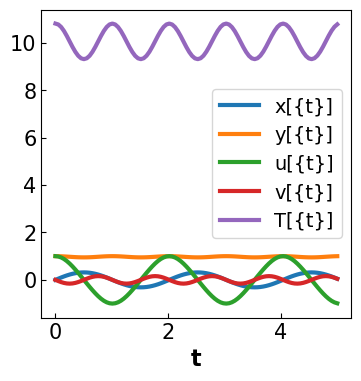

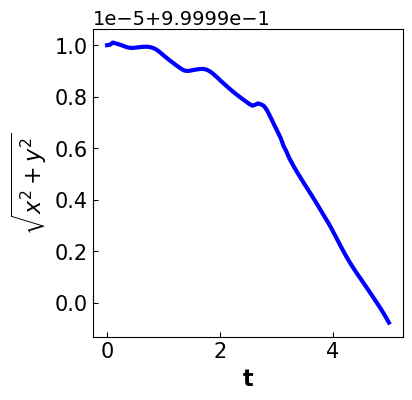

In [11]:
index1_b = create_model_index1_b()

# Specify integrator options
int_ops = {'print_stats':True,"abstol":1E-8,"reltol":1E-6}

# Solve DAEs
sim = Simulator(index1_b, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator='idas',integrator_options=int_ops)

# Plot solution
plot_results(sim, tsim, profiles)

## 2.4.4 Take Away Messages
1. Differential algebriac equations (DAEs) are really powerful modeling tools.
2. Integrating DAEs requires special care. Make sure your model is index 1.
3. Often there are many ways to reformulate the DAE model. But the numeric integrator only enforces error tolerances on the equations that are explicitly modeled. If an algebriac constraint must be satified to a specific tolerance, include it in the DAE model (as long as it is not high index!).

## Important Topics from the Textbook
**Chapter 8: Dynamic Optimization Introduction** (Biegler, 2010)
-	Chemical engineering examples
-	Classical (variational) approaches including Hamiltonian and Euler-Lagrange equations

![](https://raw.githubusercontent.com/ndcbe/optimization/main/media/dynamic_optimization_strategies.png)

**Chapter 9: Sequential Methods** (Biegler, 2010)
-	DAE integration 
-	Single Shooting
-	Multiple Shooting

![](https://raw.githubusercontent.com/ndcbe/optimization/main/media/sequential_dae_optimization.png)

**Chapter 10: Simultaneous Methods** (Biegler, 2010)
-	Gauss quadrature
-	Orthogonal collocation on finite elements
-	Examples, benchmarks, and large-scale extensions